# News Classifier

### Импорт библиотек

In [39]:
import os
os.environ["HF_HUB_DISABLE_PROGRESS_BAR"] = "1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
import re
import random
import pymorphy3

from pathlib import Path
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from transformers import AutoModel, AutoTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Загрузка датасета и EDA

In [7]:
data_dir = Path("data")
file_name = "all_news_2025-12-23.csv"
file_path = data_dir / file_name
df = pd.read_csv(file_path, parse_dates=['Publication Date'])

df_filtered = df.copy()
politics_indices = df_filtered[df_filtered['Topic'] == 'Politics'].index
keep_percentage = 0.2
n_politics_to_keep = int(len(politics_indices) * keep_percentage)
random.seed(42)
politics_to_keep = random.sample(list(politics_indices), n_politics_to_keep)
mask_keep = df_filtered.index.isin(politics_to_keep) | (df_filtered['Topic'] != 'Politics')
df = df_filtered[mask_keep].copy()

display(df)

,Website,Title,Author,Publication Date,Link,Picture Link,Category,Topic,Relevance
0,RT,Corruption-hit aide still calling shots in Kie...,RT,2025-12-21 09:52:05,https://www.rt.com/russia/629835-corruption-sc...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,NaN,Unknown,2
1,RT,Google sued for using AI to snoop on users,RT,2025-11-13 15:33:13,https://www.rt.com/business/627746-google-priv...,https://mf.b37mrtl.ru/files/2025.11/thumbnail/...,Бизнес,Science and tech,1
3,Vedomosti.ru,«Рецепт счастья»: едим дома,Роман Черкасов,2025-08-22 00:01:32,https://www.vedomosti.ru/media/columns/2025/08...,https://cdn.vdmsti.ru/image/2025/6h/1djd7l/nor...,Медиа,Health,1
4,Vedomosti.ru,Банки занялись мошенниками,Ярослав Сталь,2025-10-20 00:06:33,https://www.vedomosti.ru/opinion/columns/2025/...,https://cdn.vdmsti.ru/image/2025/85/7uvh/norma...,Мнения,Economics,1
5,RT,US tech giants advising foreign workers not to...,RT,2025-12-22 03:37:02,https://www.rt.com/news/629858-us-tech-foreign...,https://mf.b37mrtl.ru/files/2025.12/thumbnail/...,Новости,Science and tech,2
...,...,...,...,...,...,...,...,...,...
3201,Vedomosti.ru,Как новые,Олег Волошин,2025-09-08 00:01:47,https://www.vedomosti.ru/opinion/columns/2025/...,https://cdn.vdmsti.ru/image/2025/6y/192axk/nor...,Мнения / Аналитика,Unknown,1
3204,Vedomosti.ru,Внедрению ИИ в строительную отрасль препятству...,Юлия Малева,2024-05-03 01:01:11,https://www.vedomosti.ru/management/articles/2...,https://cdn.vdmsti.ru/image/2024/3g/25ndb/norm...,Менеджмент / Рынок труда,Economics,1
3205,Vedomosti.ru,Мамута объяснил разницу между блокировкой и пр...,Ведомости,2025-11-18 14:47:58,https://www.vedomosti.ru/finance/news/2025/11/...,https://cdn.vdmsti.ru/image/2025/8y/vowx8/norm...,Финансы / Банки,Weather,1
3207,Vedomosti.ru,«Это была рука Бога»: карьера футбольного гени...,"""Анастасия Винницкая, Юлия Томинова-Ерашова""",2025-10-30 07:33:58,https://www.vedomosti.ru/lifestyle/galleries/2...,https://cdn.vdmsti.ru/image/2025/8d/zv7c6/norm...,Стиль жизни / Спорт,Sport,1


После загрузки датасета из него была удалена часть строк, относящихся к теме «Politics», чтобы частично исключить дисбаланс классов

#### Анализ датасета

In [8]:
print("1. Общая информация:")
print("-"*40)
print(df.info())
    
print("\n2. Статистика признаков:")
print("-"*40)
display(df.describe(include='all').T)
    
print("\n3. Пропуски в данных:")
print("-"*40)
missing_data = pd.DataFrame({
    'Количество': df.isnull().sum(),
    'Доля в процентах': (df.isnull().sum() / len(df)) * 100
}).sort_values('Количество', ascending=False)
  
display(missing_data[missing_data['Количество'] > 0])
    
print("\n4. Уникальные значения по признакам:")
print("-"*40)
unique_counts = {}
for col in df.columns:
    unique_counts[col] = df[col].nunique()
unique_df = pd.DataFrame({
    'Колонка': list(unique_counts.keys()),
    'Количество уникальных значений': list(unique_counts.values())
})
display(unique_df)

print("\n5. Статистика по категориям:")
print("-"*40)

print("\n5.1 Распределение по веб-сайтам:")
website_stats = df['Website'].value_counts()
print(f"Всего сайтов: {website_stats.shape[0]}")
display(website_stats)

print("\n5.2 Распределение по темам (Topic):")
topic_stats = df['Topic'].value_counts()
display(topic_stats)

print("\n5.3 Распределение релевантности (Relevance):")
relevance_stats = df['Relevance'].value_counts().sort_index()
display(relevance_stats)

print("\n5.4 Статистика релевантности:")
print(f"Средняя релевантность: {df['Relevance'].mean():.2f}")
print(f"Медианная релевантность: {df['Relevance'].median():.2f}")
print(f"Минимальная релевантность: {df['Relevance'].min()}")
print(f"Максимальная релевантность: {df['Relevance'].max()}")

print("\n5.5 Распределение по категориям (Category):")
category_stats = df['Category'].value_counts().head(15)
display(category_stats)

print("\n6. Временные характеристики:")
print("-"*40)

df['Date'] = df['Publication Date'].dt.date
df['Hour'] = df['Publication Date'].dt.hour
df['DayOfWeek'] = df['Publication Date'].dt.day_name()
df['Month'] = df['Publication Date'].dt.month_name()

print("\n6.1 Количество новостей по дням:")
daily_stats = df['Date'].value_counts().sort_index()
print(f"Период охвата: {daily_stats.index.min()} - {daily_stats.index.max()}")
print(f"Всего дней: {daily_stats.shape[0]}")
print(f"Среднее количество новостей в день: {daily_stats.mean():.1f}")

print("\n7. Статистика заголовков:")
print("-"*40)

df['Title_Length'] = df['Title'].apply(lambda x: len(str(x)))
df['Title_Word_Count'] = df['Title'].apply(lambda x: len(str(x).split()))

print(f"Средняя длина заголовка: {df['Title_Length'].mean():.1f} символов")
print(f"Максимальная длина: {df['Title_Length'].max()} символов")
print(f"Минимальная длина: {df['Title_Length'].min()} символов")
print(f"Среднее количество слов: {df['Title_Word_Count'].mean():.1f}")

1. Общая информация:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 1876 entries, 0 to 3209
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Website           1876 non-null   object        
 1   Title             1876 non-null   object        
 2   Author            1799 non-null   object        
 3   Publication Date  1876 non-null   datetime64[ns]
 4   Link              1876 non-null   object        
 5   Picture Link      1677 non-null   object        
 6   Category          1675 non-null   object        
 7   Topic             1876 non-null   object        
 8   Relevance         1876 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(7)
memory usage: 146.6+ KB
None

2. Статистика признаков:
----------------------------------------


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Website,1876,6,Vedomosti.ru,1199,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Title,1876,1763,Для IT-компаний определили обязательства финан...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author,1799,308,Ведомости,468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publication Date,1876,NaN,NaN,NaN,2025-10-23 18:27:50.351812352,2023-10-22 23:50:36,2025-10-09 15:36:47.500000,2025-12-05 10:11:44,2025-12-20 15:23:35.750000128,2025-12-23 23:11:51,NaN
Link,1876,1764,https://lenta.ru/articles/2025/12/10/evreyskie...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Picture Link,1677,1566,https://cdn.vdmsti.ru/image/2025/9l/1bb57z/nor...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Category,1675,74,Мнения,292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Topic,1876,11,Economics,430,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance,1876.0,NaN,NaN,NaN,1.527719,1.0,1.0,1.0,1.0,5.0,1.065723



3. Пропуски в данных:
----------------------------------------


,Количество,Доля в процентах
Category,201,10.714286
Picture Link,199,10.607676
Author,77,4.104478



4. Уникальные значения по признакам:
----------------------------------------


,Колонка,Количество уникальных значений
0,Website,6
1,Title,1763
2,Author,308
3,Publication Date,1758
4,Link,1764
5,Picture Link,1566
6,Category,74
7,Topic,11
8,Relevance,5



5. Статистика по категориям:
----------------------------------------

5.1 Распределение по веб-сайтам:
Всего сайтов: 6


Website
Vedomosti.ru    1199
RT               344
Lenta.ru         175
RG               100
TASS              56
Gazeta.ru          2
Name: count, dtype: int64


5.2 Распределение по темам (Topic):


Topic
Economics              430
Unknown                386
Politics               333
Science and tech       250
Culture                130
Society                126
Health                  76
Sport                   45
Travels and tourism     39
Weather                 31
Accidents               30
Name: count, dtype: int64


5.3 Распределение релевантности (Relevance):


Relevance
1    1416
2     176
3      93
4     136
5      55
Name: count, dtype: int64


5.4 Статистика релевантности:
Средняя релевантность: 1.53
Медианная релевантность: 1.00
Минимальная релевантность: 1
Максимальная релевантность: 5

5.5 Распределение по категориям (Category):


Category
Мнения                                      292
Россия                                      109
Финансы / Банки                              85
Поп-культура                                 65
Недвижимость / Коммерческая недвижимость     60
Новости                                      60
Бизнес                                       54
Недвижимость / Жилая недвижимость            47
Экономика / Макроэкономика и бюджет          47
Стиль жизни / Культура                       43
Технологии / Интернет и digital              42
Менеджмент / Рынок труда                     39
Авто / Автомобильная промышленность          38
Авто / Легковые автомобили                   37
Финансы                                      33
Name: count, dtype: int64


6. Временные характеристики:
----------------------------------------

6.1 Количество новостей по дням:
Период охвата: 2023-10-22 - 2025-12-23
Всего дней: 270
Среднее количество новостей в день: 6.9

7. Статистика заголовков:
----------------------------------------
Средняя длина заголовка: 59.3 символов
Максимальная длина: 131 символов
Минимальная длина: 9 символов
Среднее количество слов: 8.7


#### Построение графиков

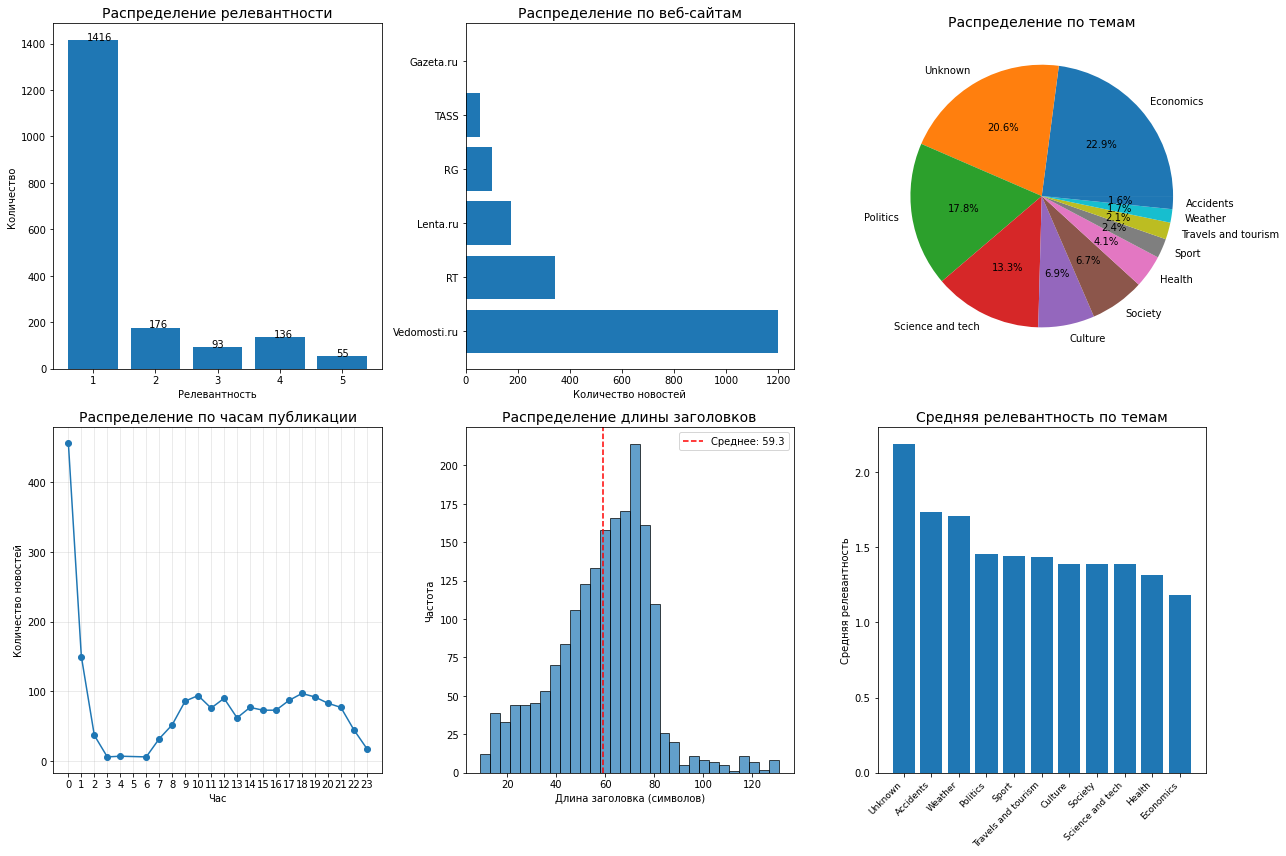

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].bar(df['Relevance'].value_counts().sort_index().index, 
               df['Relevance'].value_counts().sort_index().values)
axes[0, 0].set_title('Распределение релевантности', fontsize=14)
axes[0, 0].set_xlabel('Релевантность')
axes[0, 0].set_ylabel('Количество')
for i, v in enumerate(df['Relevance'].value_counts().sort_index().values):
    axes[0, 0].text(i+0.9, v + 0.5, str(v), fontsize=10)

top_websites = df['Website'].value_counts()
axes[0, 1].barh(range(len(top_websites)), top_websites.values)
axes[0, 1].set_yticks(range(len(top_websites)))
axes[0, 1].set_yticklabels(top_websites.index)
axes[0, 1].set_title('Распределение по веб-сайтам', fontsize=14)
axes[0, 1].set_xlabel('Количество новостей')

topics_counts = df['Topic'].value_counts()
axes[0, 2].pie(topics_counts.values, labels=topics_counts.index, autopct='%1.1f%%')
axes[0, 2].set_title('Распределение по темам', fontsize=14)

hour_counts = df['Hour'].value_counts().sort_index()
axes[1, 0].plot(hour_counts.index, hour_counts.values, marker='o')
axes[1, 0].set_title('Распределение по часам публикации', fontsize=14)
axes[1, 0].set_xlabel('Час')
axes[1, 0].set_ylabel('Количество новостей')
axes[1, 0].set_xticks(range(0, 24))
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(df['Title_Length'], bins=30, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Распределение длины заголовков', fontsize=14)
axes[1, 1].set_xlabel('Длина заголовка (символов)')
axes[1, 1].set_ylabel('Частота')
axes[1, 1].axvline(df['Title_Length'].mean(), color='red', linestyle='--', 
                  label=f'Среднее: {df["Title_Length"].mean():.1f}')
axes[1, 1].legend()

if 'Topic' in df.columns and 'Relevance' in df.columns:
    topic_relevance = df.groupby('Topic')['Relevance'].mean().sort_values(ascending=False)
    axes[1, 2].bar(range(len(topic_relevance)), topic_relevance.values)
    axes[1, 2].set_xticks(range(len(topic_relevance)))
    axes[1, 2].set_xticklabels(topic_relevance.index, rotation=45, ha='right')
    axes[1, 2].set_title('Средняя релевантность по темам', fontsize=14)
    axes[1, 2].set_ylabel('Средняя релевантность')
    axes[1, 2].tick_params(axis='x', labelsize=9)

plt.tight_layout()
plt.show()

Из интересного здесь можно заметить, что большинство новостей опубликовано больше чем 3 дня назад (судя по метрике релевантности), наибольшее количество новостей «опубликовано» в 0 часов 0 минут (хотя это по большей части из-за того, что при публикации был указан только день).

### Подготовка данных для обучения

#### Препроцессинг текста в заголовках

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)

    special_tokens = {}
    def save_special(match):
        token = f'<SPECIAL_{len(special_tokens)}>'
        special_tokens[token] = match.group(0)
        return token

    text = re.sub(r'[^a-zа-яё\s\-]', ' ', text)
    text = re.sub(r'(\w+)-(\w+)', r'\1 \2', text)
    text = re.sub(r'\s+', ' ', text).strip()

    tokens = text.split()
    processed_tokens = []
    for word in tokens:
        if word in all_stopwords or len(word) < 2:
            continue
        lemmatized = lemmatize_word(word)
        
        if lemmatized and len(lemmatized) > 1:
            processed_tokens.append(lemmatized)
    return ' '.join(processed_tokens)

def lemmatize_word(word, lang='auto'):
    if not word or len(word) < 2:
        return word
    if lang == 'auto':
        if re.search('[а-яё]', word):
            lang = 'ru'
        else:
            lang = 'en'
    if lang == 'ru':
        if PYMO_AVAILABLE:
            parsed = morph_ru.parse(word)[0]
            return parsed.normal_form
        else:
            return stemmer_ru.stem(word)
    else:
        for pos in ['n', 'v', 'a', 'r']:  # noun, verb, adjective, adverb
            lemmatized = lemmatizer_en.lemmatize(word, pos=pos)
            if lemmatized != word:
                return lemmatized
        return word
    
try:
    morph_ru = pymorphy3.MorphAnalyzer()
    PYMO_AVAILABLE = True
except:
    PYMO_AVAILABLE = False
lemmatizer_en = WordNetLemmatizer()
stemmer_ru = SnowballStemmer("russian")
try:
    nltk.download('stopwords', quiet=True)
    russian_stopwords = set(stopwords.words('russian'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = russian_stopwords.union(english_stopwords)
except:
    all_stopwords = set(['the', 'and', 'a', 'an', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

df_all = df.copy()
df_train = df_all.copy()

X_text = df_train['Title'].fillna('').astype(str).values
y = df_train['Topic'].values
    
X_processed = []
for text in X_text:
    processed = preprocess_text(text)
    X_processed.append(processed)
    print(text + " -> " + processed)

Corruption-hit aide still calling shots in Kiev – media -> corruption hit aide still call shot kiev medium
Google sued for using AI to snoop on users -> google sue use ai snoop user
«Рецепт счастья»: едим дома -> рецепт счастие есть дом
Банки занялись мошенниками -> банк заняться мошенник
US tech giants advising foreign workers not to leave country – media -> tech giant advise foreign worker leave country medium
"Даниил Егоров: «Важна взаимность – когда и налоговая открыта, и плательщик честен»" -> даниил егоров важный взаимность налоговый открыть плательщик честный
Роскомнадзор ограничил доступ к Roblox -> роскомнадзор ограничить доступ roblox
«Аркадия»: обратно к человеку -> аркадий обратно человек
ЦБ подготовил концепцию регулирования криптовалют в России -> цб подготовить концепция регулирование криптовалюта россия
«Море великих»: берега Бретани и знойное крымское побережье -> море великий берег бретань знойный крымский побережье
"Сергей Кирьяков: Гусеву необходимо начать работать 

#### Векторизация текста в заголовках и кодирование таргета (столбец Topic)

In [38]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.95,
    ngram_range=(1, 3),
    analyzer='word',
    stop_words=None,
    sublinear_tf=True
)
label_encoder = LabelEncoder()

X_vectorized = vectorizer.fit_transform(X_processed)
y_encoded = label_encoder.fit_transform(y)

OUTPUT_DIM = len(label_encoder.classes_)

print("Лематизированные заголовки: ", X_processed)
print("Векторизированные заголовки: ", X_vectorized)
print("Список слов: ", vectorizer.get_feature_names_out())
print("Темы: ", y)
print("Закодированные темы: ", y_encoded)

Лематизированные заголовки:  ['corruption hit aide still call shot kiev medium', 'google sue use ai snoop user', 'рецепт счастие есть дом', 'банк заняться мошенник', 'tech giant advise foreign worker leave country medium', 'даниил егоров важный взаимность налоговый открыть плательщик честный', 'роскомнадзор ограничить доступ roblox', 'аркадий обратно человек', 'цб подготовить концепция регулирование криптовалюта россия', 'море великий берег бретань знойный крымский побережье', 'сергей кирьяк гусев необходимо начать работать время отпуск', 'россия объяснить нахождение беременная женщина ряд всу', 'уралхий открыть представительский офис рядом мэрия москва', 'москва технология smart city стать повседневный реальность', 'липецкий область объявить угроза атака бпнуть', 'посетить открытие московский международный кинофестиваль', 'trump dance ymca celebrate day office video', 'минпромторг предложить изменить порядок расчёт утильсбор автомобиль', 'вячеслав володин подвести итог осенний сессия 

#### Разделение датасета по k-fold (k = 4)

In [35]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
fold_indices = []
fold_splits = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_vectorized, y_encoded), 1):
    fold_indices.append((train_idx, val_idx))
    fold_splits.append({
        'fold': fold,
        'train_size': len(train_idx),
        'val_size': len(val_idx),
        'train_classes': np.bincount(y_encoded[train_idx]),
        'val_classes': np.bincount(y_encoded[val_idx])
    })

#### Проверка распределения по фолдам

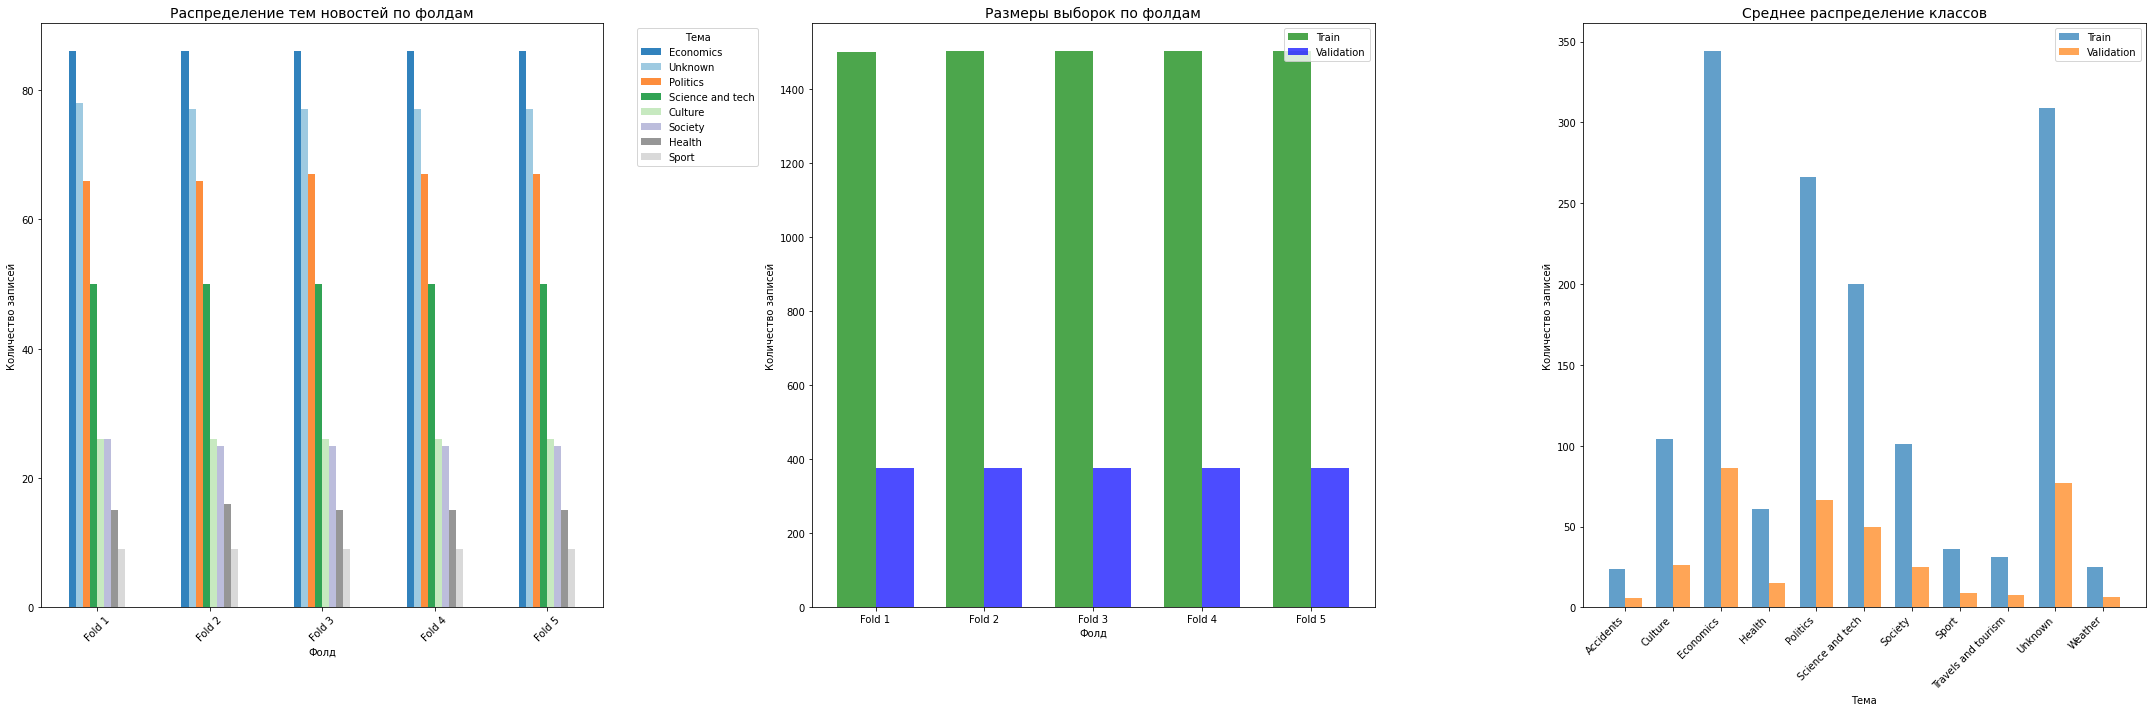

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

fold_data = []
for fold_info in fold_splits:
    val_classes = fold_info['val_classes']
    fold_data.append(val_classes)

fold_df = pd.DataFrame(fold_data, index=[f'Fold {i+1}' for i in range(n_splits)])
fold_df.columns = label_encoder.classes_



top_topics = fold_df.sum().nlargest(8).index
fold_df[top_topics].plot(kind='bar', ax=axes[0], colormap='tab20c')
axes[0].set_title('Распределение тем новостей по фолдам', fontsize=14)
axes[0].set_xlabel('Фолд')
axes[0].set_ylabel('Количество записей')
axes[0].legend(title='Тема', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].tick_params(axis='x', rotation=45)



train_sizes = [fold_info['train_size'] for fold_info in fold_splits]
val_sizes = [fold_info['val_size'] for fold_info in fold_splits]

x = np.arange(n_splits)
width = 0.35

axes[1].bar(x - width/2, train_sizes, width, label='Train', alpha=0.7, color='green')
axes[1].bar(x + width/2, val_sizes, width, label='Validation', alpha=0.7, color='blue')
axes[1].set_title('Размеры выборок по фолдам', fontsize=14)
axes[1].set_xlabel('Фолд')
axes[1].set_ylabel('Количество записей')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'Fold {i+1}' for i in range(n_splits)])
axes[1].legend()



train_class_means = np.mean([fold_info['train_classes'] for fold_info in fold_splits], axis=0)
val_class_means = np.mean([fold_info['val_classes'] for fold_info in fold_splits], axis=0)

x_pos = np.arange(len(label_encoder.classes_))
width = 0.35

axes[2].bar(x_pos - width/2, train_class_means, width, label='Train', alpha=0.7)
axes[2].bar(x_pos + width/2, val_class_means, width, label='Validation', alpha=0.7)
axes[2].set_title('Среднее распределение классов', fontsize=14)
axes[2].set_xlabel('Тема')
axes[2].set_ylabel('Количество записей')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(label_encoder.classes_, rotation=45, ha='right')
axes[2].legend()

plt.tight_layout()
plt.show()

### Поиск моделей для обучения и обучение

#### Проверка моделей классического машинного обучения

In [37]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=100000, class_weight='balanced', random_state=42, n_jobs=-1), # Логистическая регрессия
    'SVC': SVC(kernel='linear', class_weight='balanced', random_state=42, max_iter=100000), # Метод опорных векторов
    'RandomForest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, n_jobs=-1, verbose=0), # Случайный лес
    'MultinomialNB': MultinomialNB(), # Мультиномиальный наивный Байес
}
cv_results_acc = {}
cv_results_f1 = {}

for model_name, model in models.items():
    print(f"\nТестирование модели: {model_name}")
    try:
        cv_scores_acc = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='accuracy', n_jobs=-1)
        cv_results_acc[model_name] = {
            'mean_accuracy': cv_scores_acc.mean(),
            'std_accuracy': cv_scores_acc.std(),
            'scores': cv_scores_acc
        }
        cv_scores_f1 = cross_val_score(model, X_vectorized, y_encoded, cv=skf, scoring='f1_weighted', n_jobs=-1)
        cv_results_f1[model_name] = {
            'mean_f1': cv_scores_f1.mean(),
            'std_f1': cv_scores_f1.std(),
            'scores': cv_scores_f1
        }
        print(f"Средняя точность: {cv_scores_acc.mean():.3f} (+/- {cv_scores_acc.std():.3f})")
        print(f"Точность по фолдам: {cv_scores_acc}")
        print(f"Средний f1-score: {cv_scores_f1.mean():.3f} (+/- {cv_scores_f1.std():.3f})")
        print(f"F1-score по фолдам: {cv_scores_f1}")
        
    except Exception as e:
        print(f"Ошибка при обучении модели: {e}")
        cv_results_acc[model_name] = None
        cv_results_f1[model_name] = None


Тестирование модели: LogisticRegression
Средняя точность: 0.505 (+/- 0.014)
Точность по фолдам: [0.52393617 0.48       0.50666667 0.50666667 0.50666667]
Средний f1-score: 0.509 (+/- 0.017)
F1-score по фолдам: [0.53289459 0.48241777 0.5046689  0.5090379  0.51757109]

Тестирование модели: SVC
Средняя точность: 0.501 (+/- 0.024)
Точность по фолдам: [0.51861702 0.47733333 0.50666667 0.53066667 0.46933333]
Средний f1-score: 0.500 (+/- 0.023)
F1-score по фолдам: [0.51225206 0.47509666 0.50332266 0.53516237 0.47400968]

Тестирование модели: RandomForest
Средняя точность: 0.502 (+/- 0.026)
Точность по фолдам: [0.50797872 0.46133333 0.528      0.528      0.48266667]
Средний f1-score: 0.496 (+/- 0.026)
F1-score по фолдам: [0.50221847 0.45255455 0.51534102 0.52795088 0.48291162]

Тестирование модели: MultinomialNB
Средняя точность: 0.440 (+/- 0.010)
Точность по фолдам: [0.42819149 0.42933333 0.44533333 0.448      0.45066667]
Средний f1-score: 0.373 (+/- 0.013)
F1-score по фолдам: [0.35689909 0.3

Судя по выведенным метрикам, наилучшей моделью классического машинного обучения для нашего датасета является логистическая регрессия или случайный лес (при заданных параметрах).
Можно заметить, что accuracy оказалась довольно низкой, такие результаты могут оказаться из-за частично перекрывающихся тем (один и тот же заголовок может быть отнесён к нескольким темам сразу), и для классических моделей этот результат довольно неплохой

In [26]:
test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Учёные создали прототип 70-кубитного квантового компьютера",
    "Курс доллара достиг исторического максимума на бирже",
    "Пожар в жилом доме унес жизни трех человек"
]

models['LogisticRegression'].fit(X_vectorized, y_encoded)

print("Примеры предсказаний:")
for title in test_examples:
    processed = preprocess_text(title)
    vectorized = vectorizer.transform([processed])
    prediction_encoded = models['LogisticRegression'].predict(vectorized)[0]
    prediction_label = label_encoder.inverse_transform([prediction_encoded])[0] 
    print(f"'{title}' -> {prediction_label}")

Примеры предсказаний:
'Новые санкции США против России вступили в силу сегодня' -> Politics
'Футбольный матч закончился со счетом 2:1 в пользу домашней команды' -> Sport
'Учёные создали прототип 70-кубитного квантового компьютера' -> Science and tech
'Курс доллара достиг исторического максимума на бирже' -> Economics
'Пожар в жилом доме унес жизни трех человек' -> Accidents


### Проверка нейронных сетей

#### Подготовка датасета и классификатора

In [33]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long)
        }

In [28]:
class BertClassifier(nn.Module):
    def __init__(self, output_dim, model_name):
        super(BertClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        
        self.bert_hidden_dim = self.bert.config.hidden_size
        
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert_hidden_dim, output_dim)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]
        
        output = self.drop(pooled_output)
        return self.out(output)

In [29]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

train_x, val_x, train_y, val_y = train_test_split(
    X_processed, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

MODEL_NAME = 'cointegrated/rubert-tiny2'
MAX_LEN = 64
BATCH_SIZE = 32
LR = 0.0005
NUM_EPOCHS = 30

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = BertDataset(train_x, train_y, tokenizer, MAX_LEN)
val_dataset = BertDataset(val_x, val_y, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = BertClassifier(OUTPUT_DIM, MODEL_NAME).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

Используется устройство: cuda
GPU: NVIDIA GeForce GTX 1660 Ti


#### Обучение нейронной сети BERT (Bidirectional Encoder Representations from Transformers)

In [30]:
train_losses = []
val_losses = []
val_acc_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        _, preds = torch.max(outputs, dim=1)
        correct_train += torch.sum(preds == targets)
        total_train += targets.size(0)
        
    avg_train_loss = total_loss / len(train_loader)
    train_acc = correct_train.double() / total_train
    train_losses.append(avg_train_loss)



    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, dim=1)
            correct_val += torch.sum(preds == targets)
            total_val += targets.size(0)
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct_val.double() / total_val
    val_losses.append(avg_val_loss)
    val_acc_history.append(val_acc.item() * 100)
    
    scheduler.step(avg_val_loss)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

Epoch 1/30 | Train Loss: 1.8452 | Val Loss: 1.6440 | Val Acc: 0.4600
Epoch 2/30 | Train Loss: 1.0978 | Val Loss: 1.6201 | Val Acc: 0.5382
Epoch 3/30 | Train Loss: 0.4157 | Val Loss: 2.0349 | Val Acc: 0.5240
Epoch 4/30 | Train Loss: 0.1687 | Val Loss: 2.3344 | Val Acc: 0.5044
Epoch 5/30 | Train Loss: 0.0853 | Val Loss: 2.5852 | Val Acc: 0.5293
Epoch 6/30 | Train Loss: 0.0533 | Val Loss: 2.6366 | Val Acc: 0.5240
Epoch 7/30 | Train Loss: 0.0434 | Val Loss: 2.5724 | Val Acc: 0.5400
Epoch 8/30 | Train Loss: 0.0369 | Val Loss: 2.6900 | Val Acc: 0.5346
Epoch 9/30 | Train Loss: 0.0326 | Val Loss: 2.7173 | Val Acc: 0.5453
Epoch 10/30 | Train Loss: 0.0320 | Val Loss: 2.7039 | Val Acc: 0.5435
Epoch 11/30 | Train Loss: 0.0257 | Val Loss: 2.7191 | Val Acc: 0.5471
Epoch 12/30 | Train Loss: 0.0266 | Val Loss: 2.7338 | Val Acc: 0.5417
Epoch 13/30 | Train Loss: 0.0212 | Val Loss: 2.7410 | Val Acc: 0.5400
Epoch 14/30 | Train Loss: 0.0220 | Val Loss: 2.7502 | Val Acc: 0.5382
Epoch 15/30 | Train Loss: 0.0

#### Построение графиков

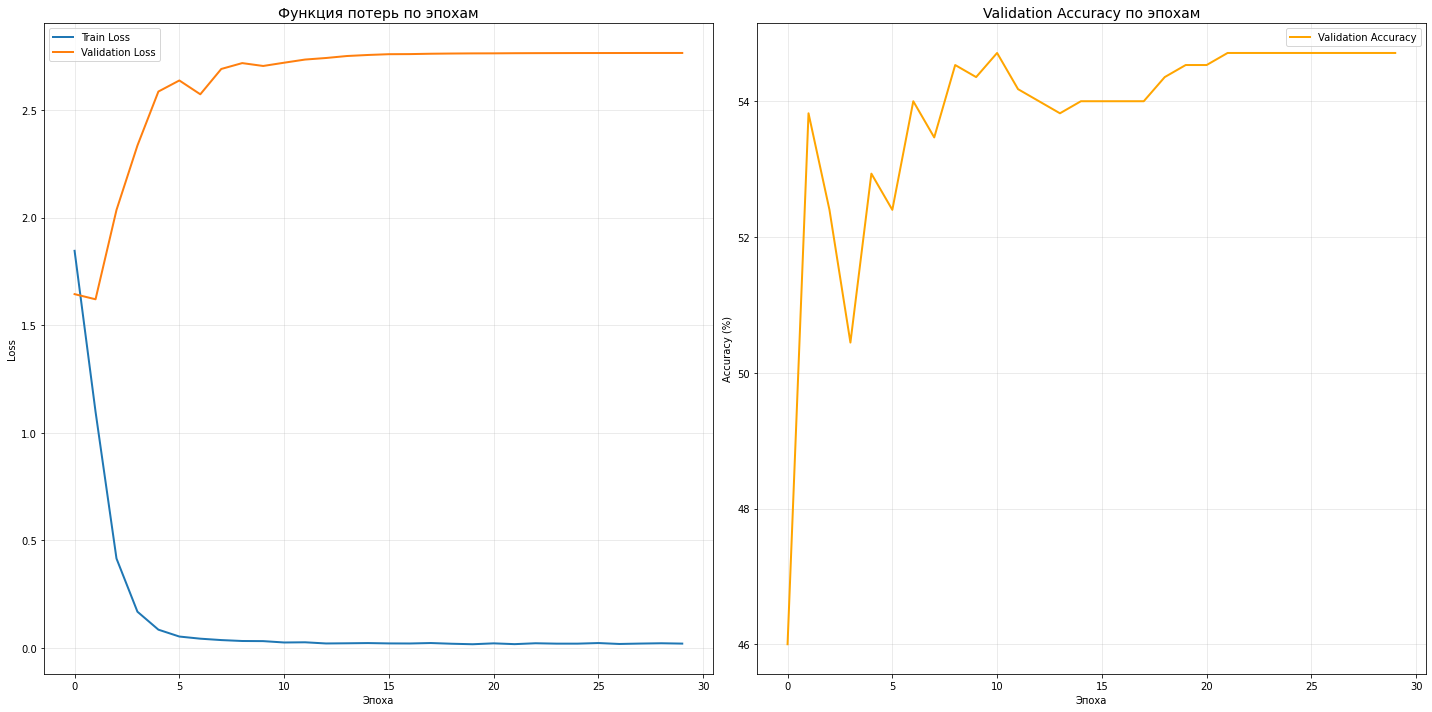

Classification Report
                     precision    recall  f1-score   support

          Accidents       0.60      0.67      0.63         9
            Culture       0.51      0.46      0.49        39
          Economics       0.67      0.84      0.75       129
             Health       0.46      0.52      0.49        23
           Politics       0.62      0.61      0.61       100
   Science and tech       0.42      0.36      0.39        75
            Society       0.44      0.37      0.40        38
              Sport       0.45      0.38      0.42        13
Travels and tourism       0.14      0.08      0.11        12
            Unknown       0.48      0.47      0.48       116
            Weather       0.00      0.00      0.00         9

           accuracy                           0.55       563
          macro avg       0.44      0.43      0.43       563
       weighted avg       0.53      0.55      0.53       563



In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_title('Функция потерь по эпохам', fontsize=14)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(val_acc_history, label='Validation Accuracy', linewidth=2, color='orange')
axes[1].set_title('Validation Accuracy по эпохам', fontsize=14)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



all_predictions = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        
        all_predictions.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

report = classification_report(all_targets, all_predictions, target_names=label_encoder.classes_, zero_division=0)
print("Classification Report")
print(report)

#### Проверка на новых заголовках

In [32]:
def predict_text(text, model, tokenizer, label_encoder, max_len=MAX_LEN):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        output = model(input_ids, attention_mask)
        probabilities = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(probabilities, dim=1).item()
    
    top3_probs, top3_indices = torch.topk(probabilities, 3)
    predicted_class = label_encoder.classes_[pred_idx]
    confidence = probabilities[0][pred_idx].item()

    top3_predictions = []
    for i in range(3):
        class_idx = top3_indices[0, i].item()
        class_name = label_encoder.classes_[class_idx]
        prob = top3_probs[0, i].item()
        top3_predictions.append((class_name, prob))
    
    return predicted_class, confidence, top3_predictions

test_examples = [
    "Новые санкции США против России вступили в силу сегодня",
    "Футбольный матч закончился со счетом 2:1 в пользу домашней команды",
    "Учёные создали прототип 70-кубитного квантового компьютера",
    "Курс доллара достиг исторического максимума на бирже",
    "Пожар в жилом доме унес жизни трех человек"
]

print("Примеры предсказаний:")
for example in test_examples:
    predicted, confidence, top3 = predict_text(example, model, tokenizer, label_encoder)
    print(f"\n'{example[:60]}...'")
    print(f"Предсказанная тема: {predicted} (confidence: {confidence:.3f})")
    print(f"Топ-3 варианта:")
    for i, (topic, prob) in enumerate(top3):
        print(f"  {i+1}. {topic}: {prob:.3f}")

Примеры предсказаний:

'Новые санкции США против России вступили в силу сегодня...'
Предсказанная тема: Politics (confidence: 0.998)
Топ-3 варианта:
  1. Politics: 0.998
  2. Unknown: 0.001
  3. Economics: 0.000

'Футбольный матч закончился со счетом 2:1 в пользу домашней к...'
Предсказанная тема: Sport (confidence: 0.915)
Топ-3 варианта:
  1. Sport: 0.915
  2. Travels and tourism: 0.060
  3. Culture: 0.010

'Учёные создали прототип 70-кубитного квантового компьютера...'
Предсказанная тема: Science and tech (confidence: 0.841)
Топ-3 варианта:
  1. Science and tech: 0.841
  2. Unknown: 0.137
  3. Health: 0.015

'Курс доллара достиг исторического максимума на бирже...'
Предсказанная тема: Economics (confidence: 0.994)
Топ-3 варианта:
  1. Economics: 0.994
  2. Weather: 0.002
  3. Politics: 0.002

'Пожар в жилом доме унес жизни трех человек...'
Предсказанная тема: Accidents (confidence: 0.879)
Топ-3 варианта:
  1. Accidents: 0.879
  2. Health: 0.079
  3. Unknown: 0.027


Как мы видим, обученная языковая модель классифицирует заголовки по темам чуть лучше, чем классические модели (accuracy составляет около 55%)